# Matrix valued continuation: 2 orbital non interacting 2D Hubbard model

In [1]:
import sys, os
import numpy as np
from triqs.plot.mpl_interface import plt,oplot

from h5 import HDFArchive
from triqs.atom_diag import *

from triqs.gf import *
from triqs.operators import c, c_dag, n, dagger
from itertools import product


from triqs.lattice.tight_binding import TBLattice
from triqs.lattice.utils import k_space_path

from triqs_tprf.lattice import lattice_dyson_g0_wk, lattice_dyson_g0_fk

from triqs_Nevanlinna import Solver

from triqs_maxent import *

import seaborn as sns
import scienceplots
plt.style.use(['science','notebook'])
# sns.set_palette('muted')

Starting serial run at: 2023-03-10 17:16:04.929244


## Setup simple two orbital 2D Hubbard model on square lattice

In [2]:
n_orb = 2

loc = np.zeros((n_orb,n_orb))
for i in range(n_orb):
    for j in range(n_orb):
        if i != 0 and i==j:
            loc[i,j] = 0.2
        if j > i or j < i:
            loc[i,j] = -0.4
            
#nearest neighbor hopping
if n_orb == 2:
    t = np.array([[-1.,0.1],[0.1,-0.4]])
else:
    t = -1.0 * np.eye(n_orb)   
    
tp = 0.1 * np.eye(n_orb)   #next nearest neighbor hopping

hop= {  (0,0)  :  loc,
        (1,0)  :  t,       
        (-1,0) :  t,     
        (0,1)  :  t,
        (0,-1) :  t,
        (1,1)  :  tp,
        (-1,-1):  tp,
        (1,-1) :  tp,
        (-1,1) :  tp}

TB = TBLattice(units = [(1, 0, 0) , (0, 1, 0)], hoppings = hop, orbital_positions= [(0., 0., 0.)]*n_orb)

### plot dispersion along high-symmetry lines

In [3]:
n_pts = 101
G = np.array([ 0.00,  0.00,  0.00])
M = np.array([0.5, 0.5, 0.0])
X = np.array([0.5, 0.0, 0.0])
R = np.array([0.5, 0.5, 0.5])
paths = [(R, G), (G, X), (X, M), (M, G)]

kvecs, k  = k_space_path(paths, num=n_pts, bz=TB.bz)
    
e_mat = TB.fourier(kvecs)
e_val = TB.dispersion(kvecs)
eps_k = {'k': k, 'K': np.concatenate(([0],k[n_pts-1::n_pts])), 'eval': e_val, 'emat' : e_mat}

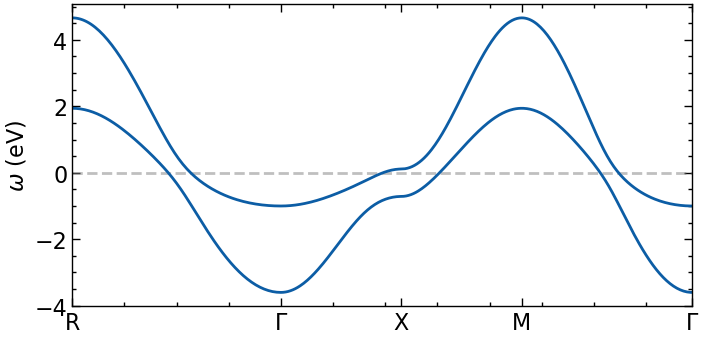

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=100, squeeze=False)
ax = ax.reshape(-1)

for band in range(eps_k['eval'].shape[1]):
    ax[0].plot(eps_k['k'], eps_k['eval'][:,band].real, color='C0', zorder=2.5)

ax[0].axhline(y=0,zorder=2,color='gray',alpha=0.5,ls='--')
ax[0].set_xticks(eps_k['K'])
ax[0].set_xticklabels([r'R', '$\Gamma$', 'X', 'M', r'$\Gamma$'])
ax[0].set_xlim([eps_k['K'].min(), eps_k['K'].max()])
ax[0].set_ylabel(r'$\omega$ (eV)')

plt.show()

## Setup lattice Green's function and calculate $G_{loc}$ on Matsubara axis

In [5]:
k_grid = (100,100,1)
k_mesh = TB.get_kmesh(n_k = k_grid)
e_k = TB.fourier(k_mesh)
eps_k = TB.dispersion(k_mesh)
mu = 0.

beta = 100
n_iw = 1000
iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_max=n_iw)
G0_iwk = lattice_dyson_g0_wk(mu=mu, e_k=e_k, mesh=iw_mesh)

### calculate local Green's function

In [6]:
G_Γ_iw = G0_iwk[:, Idx(0,0,0)] 
G_X_iw = G0_iwk[:, Idx(k_grid[1]-1,0,0)] 

G_loc_iw = Gf(mesh=iw_mesh, target_shape=(n_orb,n_orb))
iw_arr = np.array(list(iw_mesh.values()))
for k in G0_iwk.mesh[1]:
    G_loc_iw[:] += G0_iwk[:,k]
G_loc_iw = G_loc_iw / len(k_mesh)

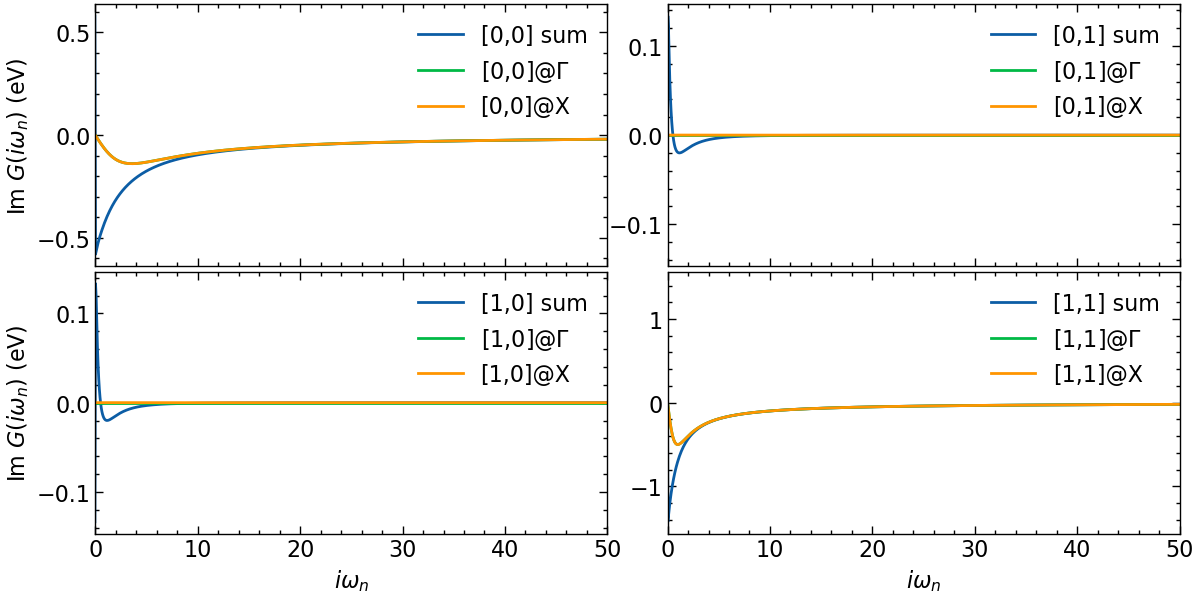

In [7]:
fig, ax = plt.subplots(n_orb, n_orb, figsize=(6*n_orb,3*n_orb), dpi=100, squeeze=False,sharex=True)

shp = G_Γ_iw.target_shape
for i in range(n_orb):
    for j in range(n_orb):
        ax[i,j].oplot(G_loc_iw[i,j].imag, label=f'[{i},{j}] sum')
        ax[i,j].oplot(G_Γ_iw[i,j].imag, label=f'[{i},{j}]@$\Gamma$')
        ax[i,j].oplot(G_X_iw[i,j].imag, label=f'[{i},{j}]@X')

        ax[i,j].set_xlim(0,50)
        
        if i == shp[0]-1:
            ax[i,j].set_xlabel(r'$i\omega_n$')
        else:
            ax[i,j].set_xlabel(r'')
        if j == 0:
            ax[i,j].set_ylabel(r'Im $G (i\omega_n)$ (eV)')
        else:
            ax[i,j].set_ylabel(r'')

plt.tight_layout(pad=0.4, w_pad=0.1, h_pad=0.4)
plt.show()

The local Green's function is off-diagonal in orbital space.

## Calculate reference data directly on real frequency axis

In [8]:
n_w = 1001
delta = 0.1
w_window = (-7, 7)
w_mesh = MeshReFreq(window=w_window, n_w=n_w)


G0_wk = lattice_dyson_g0_fk(mu=mu, e_k=e_k, mesh=w_mesh, delta=delta)

G_Γ_w = G0_wk[:, Idx(0,0,0)] 
G_X_w = G0_wk[:, Idx(k_grid[1]-1,0,0)] 

G_loc_w = Gf(mesh=w_mesh, target_shape=(n_orb,n_orb))
w_arr = np.array(list(w_mesh.values()))
for k in G0_wk.mesh[1]:
    G_loc_w[:] += G0_wk[:,k]
G_loc_w = G_loc_w / len(k_mesh)

## Analytic continuation with Pade, Nevanlinna, and MaxEnt

### Pade

In [9]:
G_loc_w_P = G_loc_w.copy()

G_loc_w_P.set_from_pade(G_loc_iw, n_points=n_iw, freq_offset=delta)

### Nevanlinna & Caratheodory

In [10]:
# setup Nevanlinna kernel solver
nevan_mesh = MeshReFreq(window=w_window, n_w=n_w//2)
solver = Solver(kernel="kernels::NEVANLINNA")

solver.solve(G_loc_iw)

G_loc_w_N = solver.evaluate(nevan_mesh, delta)

This is Nevanlinna analytical continuation. All off-diagonal elements will be ignored.


In [11]:
# setup matrix valued Nevanlinna kernel solver
solver = Solver(kernel="kernels::CARATHEODORY")

solver.solve(G_loc_iw)

G_loc_w_CN = solver.evaluate(nevan_mesh, delta)

### run MaxEnt

In [12]:
tm = PoormanMaxEnt(use_hermiticity=True)
tm.set_G_iw(G_loc_iw)
tm.set_error(1.e-5)
tm.omega = HyperbolicOmegaMesh(omega_min=w_window[0], omega_max=w_window[1], n_points=200)
tm.alpha_mesh = LogAlphaMesh(alpha_min=1e-4, alpha_max=1e2, n_points=30)
result = tm.run()
k_diag = tm.maxent_diagonal.K
k_off_diag = tm.maxent_offdiagonal.K
print(result.analyzer_results[0][0]['LineFitAnalyzer']['alpha_index'])
print(result.analyzer_results[0][1]['LineFitAnalyzer']['alpha_index'])
print(result.analyzer_results[1][1]['LineFitAnalyzer']['alpha_index'])


w_mesh_arr = np.linspace(w_mesh.omega_min, w_mesh.omega_max, len(w_mesh))
G_loc_w_ME = np.zeros((n_orb,n_orb,len(w_mesh_arr)))

for i in range(n_orb):
    for j in range(n_orb):
        G_loc_w_ME[i,j,:] = np.interp(w_mesh_arr, np.array(result.omega), result.get_A_out('LineFitAnalyzer')[i,j])

Calculating diagonal elements.
Calling MaxEnt for element 0 0
2023-03-10 17:19:32.405337
MaxEnt run
TRIQS application maxent
Copyright(C) 2018 Gernot J. Kraberger
Copyright(C) 2018 Simons Foundation
Authors: Gernot J. Kraberger and Manuel Zingl
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistributeit under certain conditions; see file LICENSE.
Please cite this code and the appropriate original papers (see documentation).

Minimal chi2: 0.04768535133605887
scaling alpha by a factor 6001 (number of data points)
alpha[ 0] =   6.00100000e+05, chi2 =   1.68505715e+04, n_iter=     346 
alpha[ 1] =   3.72672267e+05, chi2 =   9.36636420e+03, n_iter=      14 
alpha[ 2] =   2.31435791e+05, chi2 =   5.17253363e+03, n_iter=      15 
alpha[ 3] =   1.43725547e+05, chi2 =   2.85449082e+03, n_iter=      17 
alpha[ 4] =   8.92560000e+04, chi2 =   1.57641824e+03, n_iter=      19 
alpha[ 5] =   5.54294881e+04, chi2 =   8.66716051e+02, n_iter=      22 
a

## Final plot for comparison

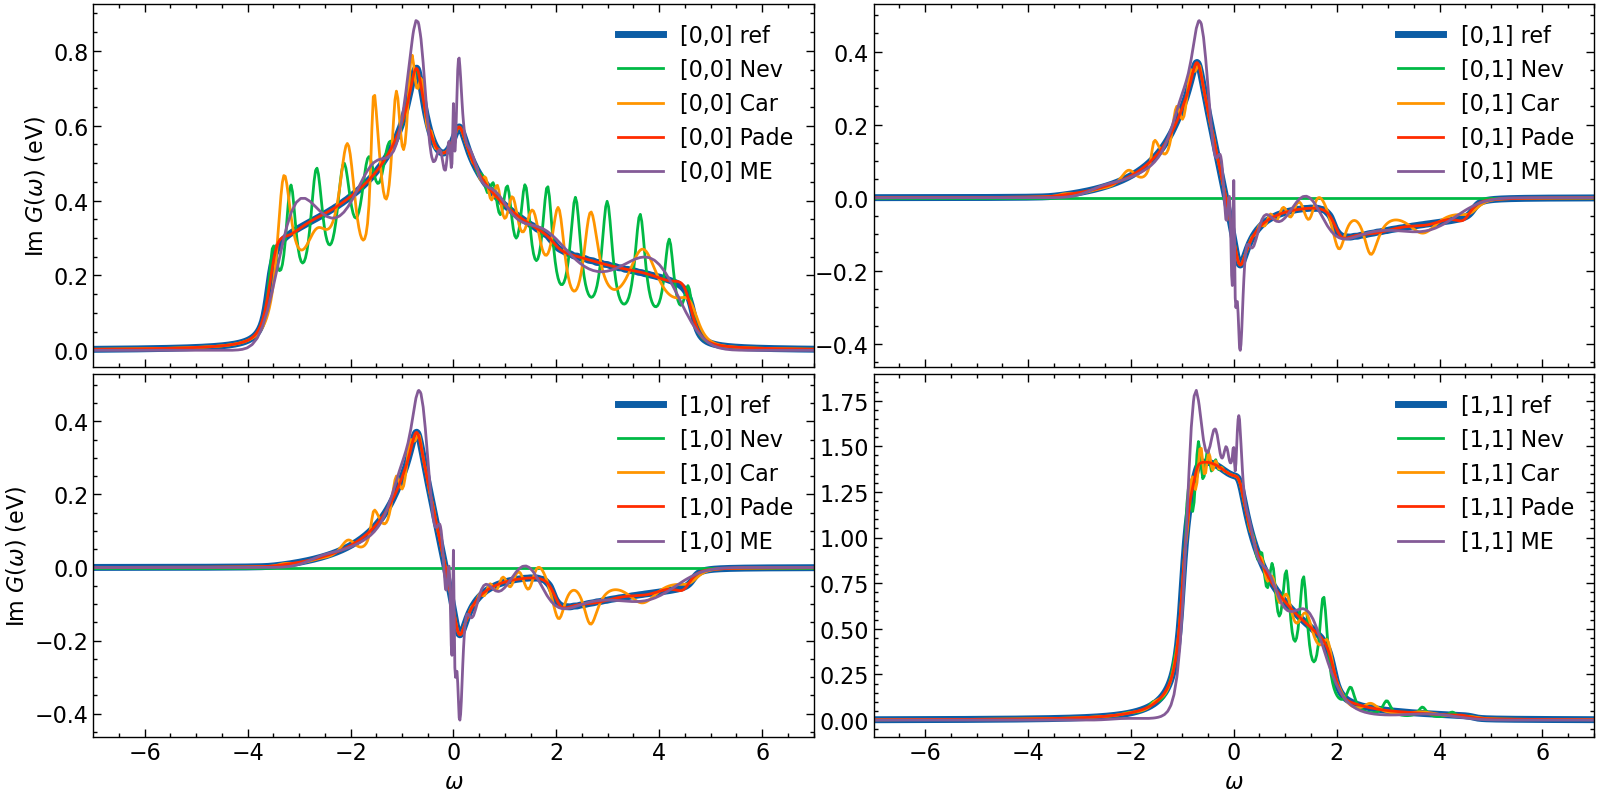

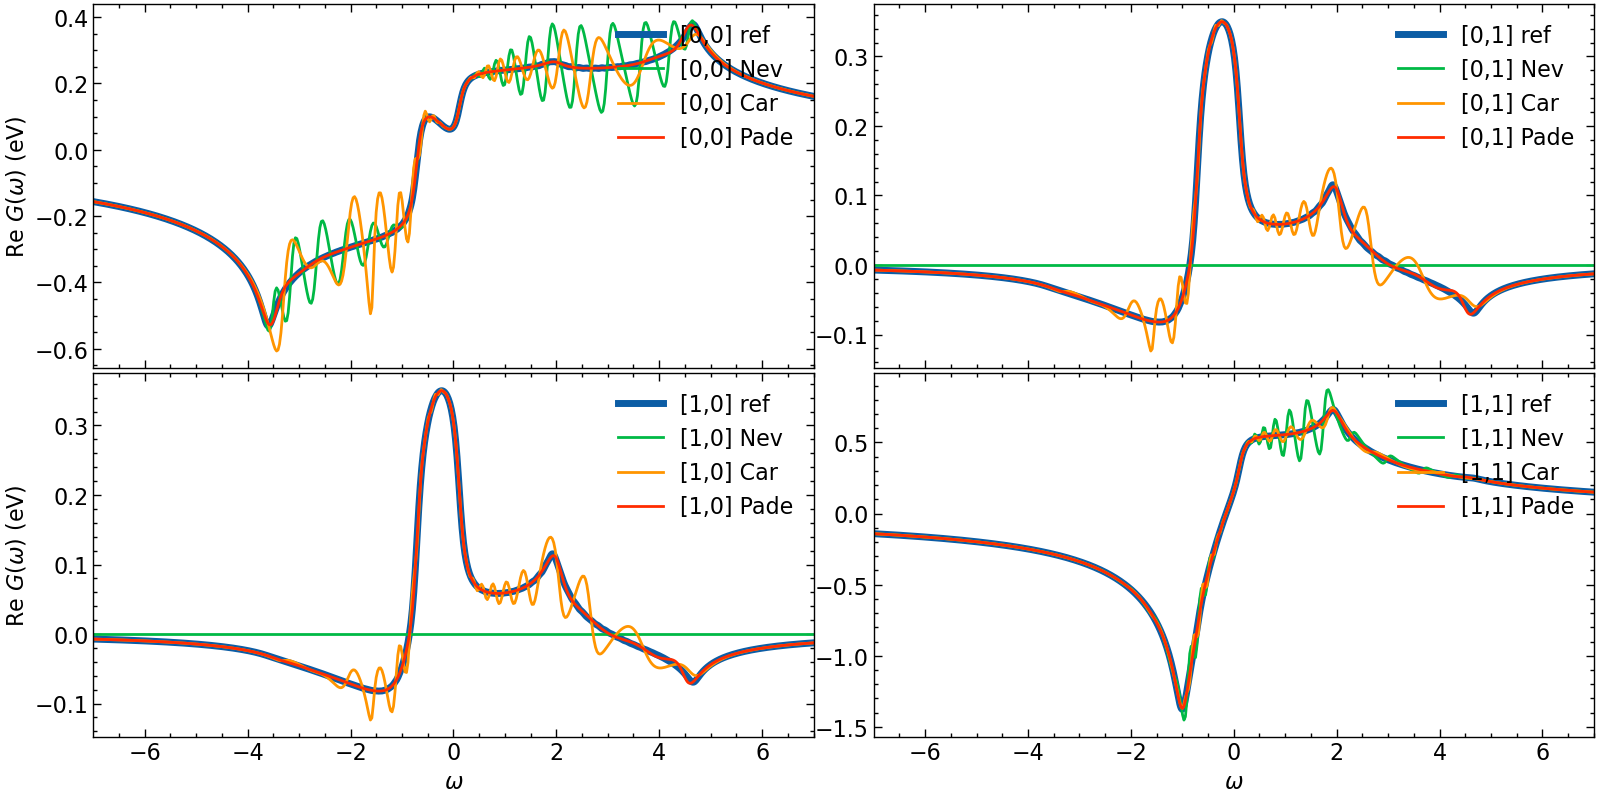

In [13]:
fig, ax = plt.subplots(n_orb, n_orb, figsize=(8*n_orb,4*n_orb), dpi=100, squeeze=False,sharex=True)

shp = G_loc_w.target_shape
for i in range(n_orb):
    for j in range(n_orb):
        # plotting results
        ax[i,j].oplot(-1*G_loc_w[i,j].imag, lw=5, label=f'[{i},{j}] ref')
        ax[i,j].oplot(-1*G_loc_w_N[i,j].imag, label=f'[{i},{j}] Nev')
        ax[i,j].oplot(-1*G_loc_w_CN[i,j].imag, label=f'[{i},{j}] Car')
        ax[i,j].oplot(-1*G_loc_w_P[i,j].imag, label=f'[{i},{j}] Pade')
        ax[i,j].plot(w_mesh_arr,np.pi*G_loc_w_ME[i,j], label=f'[{i},{j}] ME')
        
        
        ax[i,j].set_xlim(w_window)
        ax[i,j].legend()
        if i == shp[0]-1:
            ax[i,j].set_xlabel(r'$\omega$')
        else:
            ax[i,j].set_xlabel(r'')
        if j == 0:
            ax[i,j].set_ylabel(r'Im $G (\omega)$ (eV)')
        else:
            ax[i,j].set_ylabel(r'')

plt.tight_layout(pad=0.4, w_pad=0.1, h_pad=0.4)

plt.show()

fig, ax = plt.subplots(n_orb, n_orb, figsize=(8*n_orb,4*n_orb), dpi=100, squeeze=False,sharex=True)

for i in range(n_orb):
    for j in range(n_orb):
        # plotting results
        ax[i,j].oplot(G_loc_w[i,j].real, lw=5, label=f'[{i},{j}] ref')
        ax[i,j].oplot(G_loc_w_N[i,j].real, label=f'[{i},{j}] Nev')
        ax[i,j].oplot(G_loc_w_CN[i,j].real, label=f'[{i},{j}] Car')
        ax[i,j].oplot(G_loc_w_P[i,j].real, label=f'[{i},{j}] Pade')
        
        ax[i,j].set_xlim(w_window)
        if i == shp[0]-1:
            ax[i,j].set_xlabel(r'$\omega$')
        else:
            ax[i,j].set_xlabel(r'')
        if j == 0:
            ax[i,j].set_ylabel(r'Re $G (\omega)$ (eV)')
        else:
            ax[i,j].set_ylabel(r'')

plt.tight_layout(pad=0.4, w_pad=0.1, h_pad=0.4)
plt.show()